In [1]:
import cnoid.CGALUtil as cgal
exec(open('/choreonoid_ws/install/share/irsl_choreonoid/sample/irsl_import.py').read())

light_blue_color = (173/255, 216/255, 230/255)
yellow_color = (1,1,0)
red_color    = (1,0,0)
green_color  = (0, 66/255, 37/255)
black_bean_color = (61/255, 12/255, 2/255)
african_violet_color = (178/255, 132/255, 190/255)
bright_green_color = (102/255, 255/255, 0)

def makeOnEdgeTetra(from_pt, to_pt, cube_size, c_size):
    zz = to_pt - from_pt
    zz = zz/np.linalg.norm(zz)
    yy = to_pt + from_pt
    yy = yy/np.linalg.norm(yy)
    mat = np.column_stack([np.cross(yy, zz), yy, zz])
    cds=coordinates(from_pt, mat)
    #cc=mkshapes.makeTetrahedron(cube_c_size*5, cube_c_size*5, cube_size*2, center_x=cube_c_size*2.5, center_y=0.0, coords=cds)
    cc=cgal.makeTetrahedron(c_size*5, c_size*5, cube_size*2, center_x=c_size*2.5, center_y=0.0, coords=cds)
    cc.translate(npa([0, 0, -cube_size*0.05]))
    cc.translate(npa([-c_size*2.5, 0, 0]))
    cc.translate(npa([0, -c_size*0.5, 0]))
    return cc

def makeCubeWithC(cube_size, horizontal_c_size=None, vertical_c_size=None, color=None, horizontalEdge=True, verticalEdge=False):
    if horizontal_c_size is None:
        horiaontal_c_size = 0.02 * cube_size
    if vertical_c_size is None:
        vertical_c_size = 0.02 * cube_size
    res = cgal.makeBox(cube_size, color=color)
    #res = [ cgal.makeBox(cube_size, color=color) ]
    size_2 = cube_size*0.5
    lst=((1, 1), (-1, 1), (-1, -1), (1, -1))
    if horizontalEdge:
        for l in range(len(lst)):
            from_pt = npa([lst[l-1][0]*size_2, lst[l-1][1]*size_2, size_2])
            to_pt   = npa([lst[l  ][0]*size_2, lst[l  ][1]*size_2, size_2])
            obj=makeOnEdgeTetra(from_pt, to_pt, cube_size, horizontal_c_size)
            cgal.booleanDifference(res, obj)
            #res.append(obj)
        for l in range(len(lst)):
            from_pt = npa([lst[l-1][0]*size_2, lst[l-1][1]*size_2, -size_2])
            to_pt   = npa([lst[l  ][0]*size_2, lst[l  ][1]*size_2, -size_2])
            obj=makeOnEdgeTetra(from_pt, to_pt, cube_size, horizontal_c_size)
            cgal.booleanDifference(res, obj)
            #res.append(obj)
    if verticalEdge:
        for l in range(len(lst)):
            from_pt = npa([lst[l][0]*size_2, lst[l][1]*size_2, -size_2])
            to_pt   = npa([lst[l][0]*size_2, lst[l][1]*size_2,  size_2])
            obj=makeOnEdgeTetra(from_pt, to_pt, cube_size, vertical_c_size)
            cgal.booleanDifference(res, obj)
            #res.append(obj)
    return res

def makeConnectedCubes(lst, color, cube_size=1.0, cube_c_size=0.04):
    res = []
    for l in lst:
        obj = makeCubeWithC(cube_size, cube_c_size, color=color)
        obj.translate( cube_size * npa(l) )
        res.append(obj)
    return res

def makeConnectedCubesScen(lst, fname, color=None, cube_size=1.0, uri=None):
    res = []
    if uri is None:
        uri = fname
    for l in lst:
        obj = mkshapes.loadScene(fname, fileUri=uri, color=color)
        obj.translate( cube_size * npa(l) )
        res.append(obj)
    return res

def makeConnectedCubesPrimitive(lst, color=None, cube_size=1.0):
    res = []
    for l in lst:
        obj = mkshapes.makeBox(cube_size, color=color)
        obj.translate( cube_size * npa(l) )
        res.append(obj)
    return res

#settings=((0, 0, 0), (0, -1, 0), (0,  0, 1), (0, 1, 1))
def createCubes(name, settings, size, c_size, color=None, dirname='', mode=2, URDF=False, meshURLPrefix=''):
    obj = makeCubeWithC(size, horizontal_c_size=c_size, vertical_c_size=c_size,
                        horizontalEdge=True, verticalEdge=True)
    fname = '{}cube_with_c.scen'.format(dirname)
    mkshapes.exportScene(fname, obj.target, exportMesh=True)
    vis = makeConnectedCubesScen(settings, fname, color=color, cube_size=size)
    col = makeConnectedCubesPrimitive(settings, cube_size=size)
    # Builder
    rb=RobotBuilder()
    # visual
    rb.addShapes(vis)
    # collision
    gcol = cutil.SgGroup()
    for c in col:
        gcol.addChild(c.target)
    ### for zero division / calc mass from collision
    lcur=rb.createLinkFromShape(name='base_link', root=True, density=200, collision=gcol, useCollisionForMassparam=True)
    if URDF:
        urdffname='{}{}.urdf'.format(dirname, name)
        rb.exportURDF(urdffname, RobotName=name, UseURDFPrimitiveGeometry=True, UseXacro=False, MeshURLPrefix=meshURLPrefix, MeshFilePrefix=dirname)
    else:
        bodyfname='{}{}.body'.format(dirname, name)
        rb.exportBody(bodyfname, mode=mode, modelName=name)

In [2]:
import os

CUBE_SIZE = 0.03
CUBE_C_SIZE=0.001
_meshprefix='package://irsl_sim_environments/urdf/puzzle_blocks/'
_URDF=False
_outputdir='/tmp/cnoid/'
#_URDF=True
#_outputdir='/tmp/urdf/'

def loadRobot(file):
    ritm=ib.loadRobotItem(file)
    return RobotModel(ritm)

def deleteRobot():
    w=ib.getOrAddWorld()
    w.removeFromParentItem()

import random
def setRandomCamera():
    theta = random.gauss(0, PI/2)
    elv   = random.gauss(0, PI/4)
    ar = IC.normalizeVector(fv(math.sin(theta), math.cos(theta), math.tan(elv)))
    #ln = mkshapes.makeLines([[0, 0, 0], ar.tolist()])
    #di.addObject(ln)
    cds=ib.cameraPositionLookingAt(ar, fv(0, 0, 0), fv(0, 0, 1))
    ib.setCameraCoords(cds)
    ib.viewAll()

def setEnvironment(size=512, color=[0, 0, 0], **kwargs):
    ib.setViewSize(size, size)
    ib.setBackgroundColor(color)
    ib.disableGrid()
    ib.setCoordinateAxes(False)

def saveImage(prefix, *args):
    ib.viewAll()
    filename = prefix.format(*args)
    ib.saveImageOfScene(filename)

In [3]:
block_settings = {'yellow_block':{'color':yellow_color, 'settings': ((0, 0, 0), (0, 0, 1), (0, 1, 1), (0, 2, 1))},
                'cyan_block':{'color':light_blue_color, 'settings': ((0, 0, 0), (0, -1, 1), (0,  0, 1), (0, 1, 1))},
                'red_block':{'color':red_color, 'settings': ((0, 0, 0), (0, -1, 0), (0, 0, 1), (0, 1, 1))},
                'green_block':{'color':green_color, 'settings': ((0, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1))},
                'brown_block':{'color':black_bean_color, 'settings': ((0, 0, 0), (1, 0, 0), (0, 0, 1), (1, 0, 1))},
                'purple_block':{'color':african_violet_color, 'settings': ((0, 0, 0), (0, 0, 1), (1, 0, 1), (1, -1, 1))},
                'lightgreen_block':{'color':bright_green_color, 'settings': ((0, 0, 0), (0, 0, 1), (0, -1, 1))},
               }

In [4]:
setEnvironment()
di = DrawInterface()

In [5]:
for block_name in block_settings.keys():
    block_setting = block_settings[block_name]
    settings=block_setting['settings']
    name=block_name
    _col=block_setting['color']
    os.makedirs('{}{}/'.format(_outputdir, name), exist_ok=True)
    createCubes(name, settings, CUBE_SIZE, CUBE_C_SIZE, color=_col, dirname='{}{}/'.format(_outputdir, name),
                URDF=_URDF, meshURLPrefix='{}{}/'.format(_meshprefix, name))


In [6]:
block_name = 'red_block'
robot = loadRobot('/tmp/cnoid/{}/{}.body'.format(block_name,block_name))
setRandomCamera()

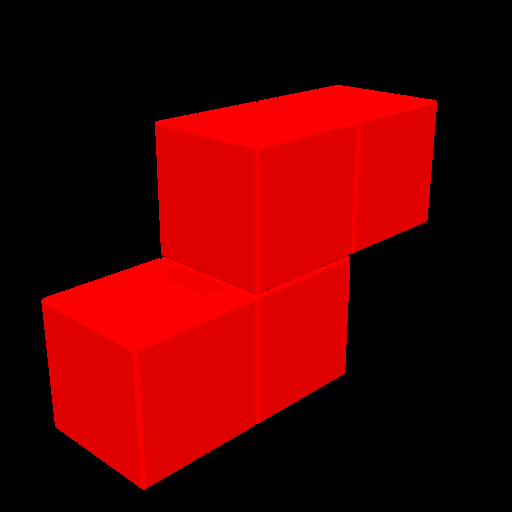

In [7]:
%display

In [8]:
tmp_image_filename = "/tmp/test.png"
saveImage(tmp_image_filename)

In [9]:
import os
os.system("pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu")
os.system("pip3 install setuptools scipy segmentation-models-pytorch")

0

0

In [10]:
import cv2
from pred_puzzle import gen_featrue_map, fit2model_p3p, gen_fitting_model
import torch
import yaml

In [11]:
device = torch.device('cpu')

image = cv2.imread(tmp_image_filename)
model = torch.load('../output-20241018014650/model_010.pth', map_location=device)

Error: 001

In [12]:
cam_mat = ib.getCameraMatrix()
dist = np.zeros((5))


with open('annotation.yaml', "r", encoding="utf-8") as f:
    anno_dat = yaml.safe_load(f)

fitting_model = gen_fitting_model(anno_dat["blocks"], issort=True)

In [13]:
(
    pred_convex,
    pred_concave,
    pred_convex_lm,
    pred_concave_lm,
    convex_pos,
    concave_pos,
) = gen_featrue_map(image, model, device, score_ths=[0.5, 0.3, 0.25, 0.2, 0.15, 0.1])

In [14]:
max_score, max_score_dat = fit2model_p3p(
                fitting_model[block_name], convex_pos, pred_convex, cam_mat, dist, itr_num=0, use_ransac=True
            )

In [15]:
(max_score, max_score_dat)

(-3.7634410283128203, {'rvec': array([[-1.14315268],
       [ 0.4723548 ],
       [ 0.67145608]]), 'tvec': array([[ 1.32944742e-04],
       [-1.41491466e-02],
       [ 1.72420958e-01]]), 'point': array([[153.        , 120.        ],
       [257.51182552, 141.93928832],
       [337.43835584,  85.82453781],
       [438.97624377,  99.48559378],
       [334.21908573, 198.83909338],
       [430.        , 223.        ],
       [256.74859099, 335.78950124],
       [349.23369464, 375.44866622],
       [ 39.78499892, 296.25970545],
       [135.28716015, 344.84704407],
       [ 54.38165301, 429.25970957],
       [145.        , 492.        ]])})

In [16]:
camera_cds, _ = ib.getCameraCoords()
rot_mat, _ = cv2.Rodrigues(max_score_dat['rvec'])
target_camera_cds = coordinates(max_score_dat['tvec'], rot_mat)
estimate_cds = camera_cds.copy().transform(target_camera_cds)

robot2 = loadRobot('/tmp/cnoid/{}/{}_inv.body'.format(block_name,block_name))
robot2.rootCoords(estimate_cds)

<coordinates[0x5dd984eef910] 3.10217e-05 0.000158501 0.030211 / 0.99994 -0.000149564 0.00968228 0.0051332 >

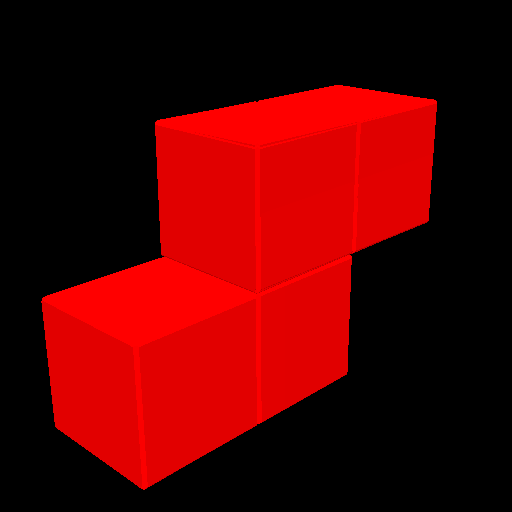

In [17]:
%display

In [23]:
deleteRobot()